In [7]:
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
from Py3BR import threebodies, analysis, plotters, constants, potentials

In [8]:
m1 = 32.06*constants.u2me  # S
m2 = 32.06*constants.u2me
m3 = 39.948*constants.u2me   # Ar
mu = np.sqrt(m1*m2*m3/(m1+m2+m3))

E0 = 300    # collision energy (K)
b0 = 0
R0 = 1150
dR0 = 115

# S-S
# c6 from 10.1021/acs.jctc.6b00361 
# de from J. Chem. Phys. 128, 204306
SS_c6 = 140
SS_de = 101.79/627.503 # Hartree
SS_rm = (SS_c6/2/SS_de)**(1/6) # 3.57 a0, unmatched
# Match rm
SS_c12 = SS_c6*SS_rm**6/2
# S-Ar
SAr_c6 = 95.27
SAr_de = 0.424/627.503 # Hartree
SAr_rm = (SAr_c6/2/SAr_de)**(1/6) # 7.16 a0, unmatched
SAr_c12 = SAr_c6*SAr_rm**6/2

# Potential parameters in atomic units
v12 = lambda x: potentials.LJ(x,m=12,n=6,cm=SS_c12,cn=SS_c6)
dv12 = lambda x: potentials.dLJ(x,m=12,n=6,cm=SS_c12,cn=SS_c6)
v23 = lambda x: potentials.LJ(x,m=12,n=6,cm=SAr_c12, cn=SAr_c6)
dv23 = lambda x:potentials.dLJ(x,m=12,n=6,cm=SAr_c12, cn=SAr_c6)
v31 = lambda x: potentials.LJ(x,m=12,n=6,cm=SAr_c12, cn=SAr_c6)
dv31 = lambda x:potentials.dLJ(x,m=12,n=6,cm=SAr_c12, cn=SAr_c6)

input_dict = {'m1': m1, 'm2':m2, 'm3':m3,
              'E0': E0, 'b0': b0, 'R0':R0,
              'dR0': dR0, 
              'v12':v12, 'v23':v23,'v31':v31,
              'dv12':dv12, 'dv23':dv23, 'dv31':dv31,
              'seed': None, 
              'integ': {'t_stop': 10, 
                      'r_stop': 3,
                      'r_tol': 1e-10,
                      'a_tol': 1e-12}}

In [231]:
opac = analysis.opacity('results/s32/short2.txt').reset_index()

In [232]:
bmax_AB,bmax_BB = analysis.bmax('results/s32/short2.txt',tol_AB=0,n_AB=3,tol_BB=0.01,n_BB=2)
bmax_BB[35] = 32.5
rate = analysis.k3('results/s32/short2.txt',mu,bmax_AB,bmax_BB).reset_index()

In [447]:
omax = {}
for ev in opac.e.unique():
    omax[ev] = opac[opac['e']==ev]['b'].max()

<IPython.core.display.Javascript object>


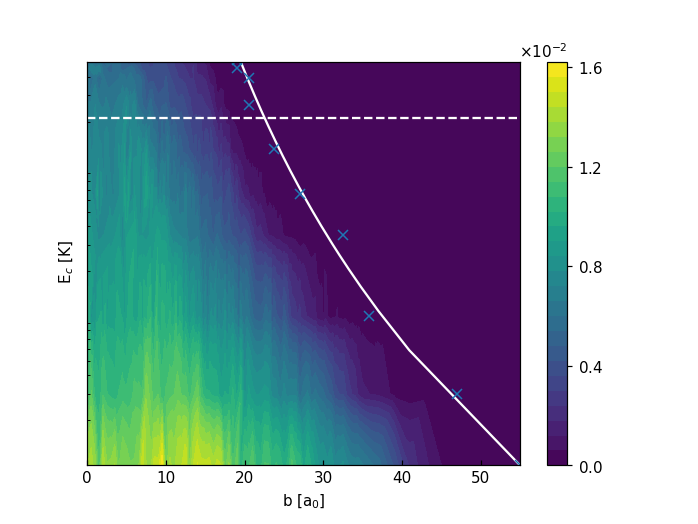

In [294]:
e = opac['e']
b = opac['b']
p = opac['pBB']
ev = np.linspace(e.min(),e.max(),1000)
tlow = 55/(opac['e'].min()**(-1/6))*ev**(-1/6)
fig, ax = plt.subplots()
CS = ax.tricontourf(b, e, p, cmap='viridis', levels=30)
plt.plot(tlow,ev, color = 'white')
plt.yscale('log')
# plt.plot(thigh,e, color = 'green')
cbformat = ticker.ScalarFormatter()
cbformat.set_scientific('%.3e')
cbformat.set_powerlimits((0,0))
cbformat.set_useMathText(True)
cbar = fig.colorbar(CS, format = cbformat,ticks=[0, 0.004,0.008,0.012,0.016])
plt.plot(bmax_BB.values(),bmax_BB.keys(),'x','white')
plt.hlines(213,0,55,linestyles='dashed',colors='white')
plt.ylim(1,500)
plt.xlim(0,55)
plt.xlabel(r'b [$\mathrm{a_0}$]')
plt.ylabel(r' E$_c$ [K]')
plt.tick_params(which='both',direction='in')
# plt.savefig('figures/s32opacity_inferno.png',dpi=300)
plt.show()

<IPython.core.display.Javascript object>


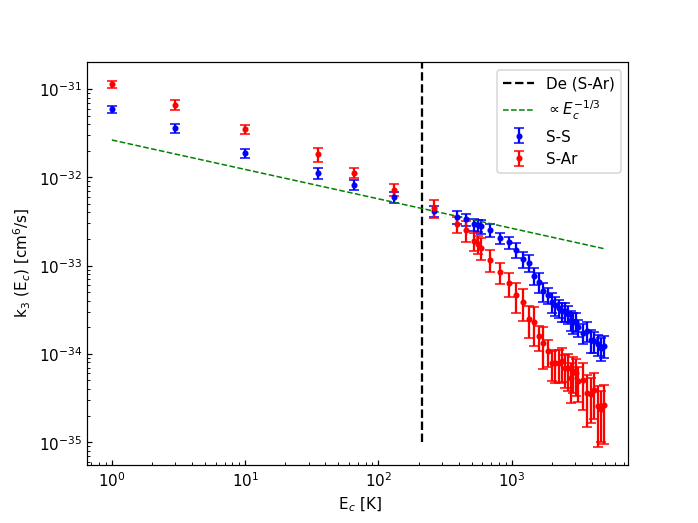

In [234]:
plt.figure()
plt.errorbar(rate['e'], rate['k3_BB'], rate['k3_BB_err'], fmt='.',capsize=3,label=r'S-S', color = 'blue')
plt.errorbar(rate['e'], rate['k3_AB'], rate['k3_AB_err'], fmt='.',capsize=3,label='S-Ar', color = 'red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r' E$_c$ [K]')
plt.ylabel(r' k$_3$ (E$_c$) [$\mathrm{cm^6/s}$]')
plt.tick_params(which='both',direction='in')
plt.vlines(213,1e-35,1e-30,linestyles='dashed',colors='black', label = 'De (S-Ar)')
plt.plot(rate['e'], (rate['k3_BB'][6]/rate['e'][6]**(-1/3))*rate['e']**(-1/3),
         'g--',linewidth=1, label = r'$\propto E_c^{-1/3}$')
plt.legend()
# plt.savefig('figures/s32rate_E.png',dpi=300)
plt.show()

In [235]:
s32r = rate.reset_index()
s32kt = {}
s32kt_err = {}
for T in range(100,500):
    s32integ = s32r['e']**2*s32r['k3_BB']*np.exp(-s32r['e']/T)/(2*T**3)
    s32integ_err = s32r['e']**2*s32r['k3_BB_err']*np.exp(-s32r['e']/T)/(2*T**3)
    s32kt[T] = integrate.trapz(s32integ,x = s32r['e'])
    s32kt_err[T] = integrate.trapz(s32integ_err,x = s32r['e'])

In [236]:
# Error bounds
s32low = [list(s32kt.values())[x] - list(s32kt_err.values())[x] for x in range(len(s32kt))]
s32high = [list(s32kt.values())[x] + list(s32kt_err.values())[x] for x in range(len(s32kt))]

In [237]:
qct = {}
for T in range(100,500):
    qct[T] = 3.94e-33*np.exp(205.56*(1/T - 1/298.15))

In [238]:
thres = pd.read_csv('results/s32/Thresholdlaw.dat', header=None)

In [105]:
import matplotlib.ticker as mticker

In [239]:
s32threshold = (s32r['k3_BB'][3]/(s32r['e'][3]**(-1/3)))*s32r['e']**(-1/3)
# T = 300
# dist = r['e']**2*threshold*np.exp(-r['e']/T)*1/(2*T**3)
# s32dist = r['e']**2*r['k3_12']*np.exp(-r['e']/T)*1/(2*T**3)
# plt.figure()
# plt.plot(r['e'],dist,'.')
# plt.plot(r['e'],s32dist,'.')
# plt.show()
s32kthres = {}
for T in range(100,500):
    s32integ_thres = s32r['e']**2*s32threshold*np.exp(-s32r['e']/T)/(2*T**3)
    s32kthres[T] = integrate.trapz(s32integ_thres,x = s32r['e'])

<IPython.core.display.Javascript object>


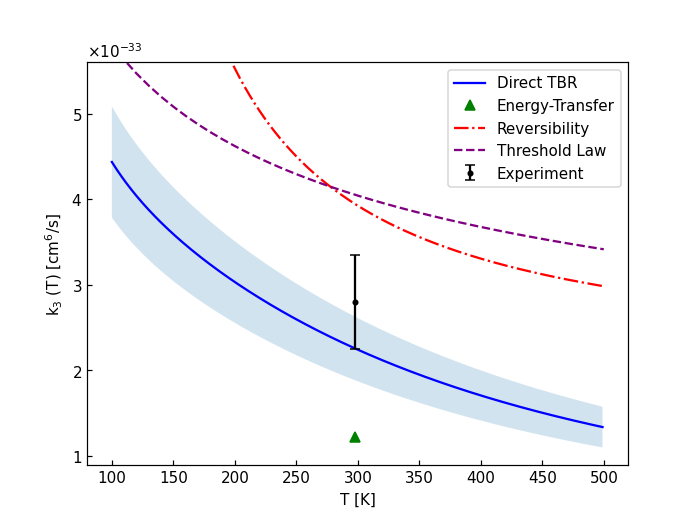

In [268]:
plt.figure()
plt.plot(s32kt.keys(),s32kt.values(),label='Direct TBR', color='blue')
plt.fill_between(s32kt.keys(), s32low, s32high, alpha=0.2)
plt.errorbar(298,2.8e-33,5.5150378e-34,fmt='.',capsize=3, color='black',label='Experiment')
plt.plot(298,1.22e-33,'^',label='Energy-Transfer', color = 'green')#10.1016/j.gca.2017.01.029
# plt.plot(298,4.19e-33,'o',label='J. Chem. Phys. 128, 204306 (2008)')
plt.plot(qct.keys(),qct.values(),'-.',label='Reversibility', color='red')#10.1063/1.2919569
plt.plot(thres[0],thres[1],linestyle='dashed',color='purple', label = 'Threshold Law')
# plt.plot(s32kthres.keys(),s32kthres.values(),linestyle='dotted',color='purple')
plt.ylabel(r'k$_3$ (T) [$\mathrm{cm^6/s}$]')
plt.xlabel('T [K]')
plt.tick_params(which='both',direction='in')
# plt.yscale('log')
# plt.gca().yaxis.set_minor_formatter(mticker.ScalarFormatter())
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.ylim(8.9e-34,5.6e-33)
plt.legend()
plt.savefig('figures/s32rate_T_lab.png',dpi=300)
plt.show()

<IPython.core.display.Javascript object>


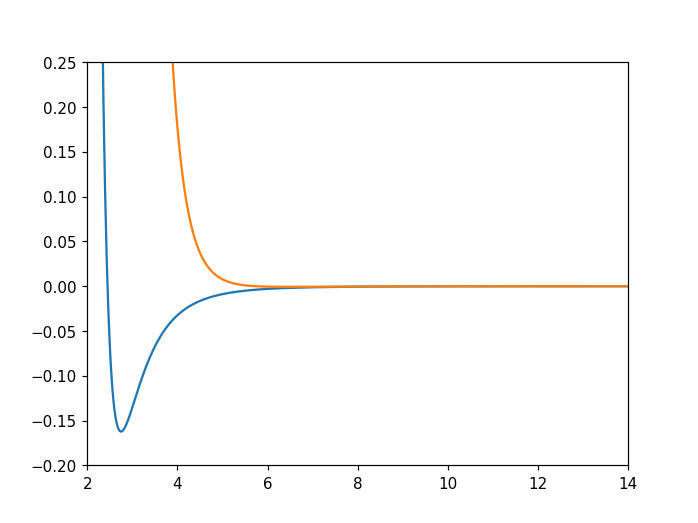

(-0.2, 0.25)

In [50]:
x = np.linspace(2,20,1000)
plt.figure()
plt.plot(x,input_dict['v12'](x), label = r'S$_2$')
plt.plot(x,input_dict['v23'](x), label = 'ArS')
plt.xlim(2,14)
plt.ylim(-.2,.25)
# plt.legend()

<IPython.core.display.Javascript object>


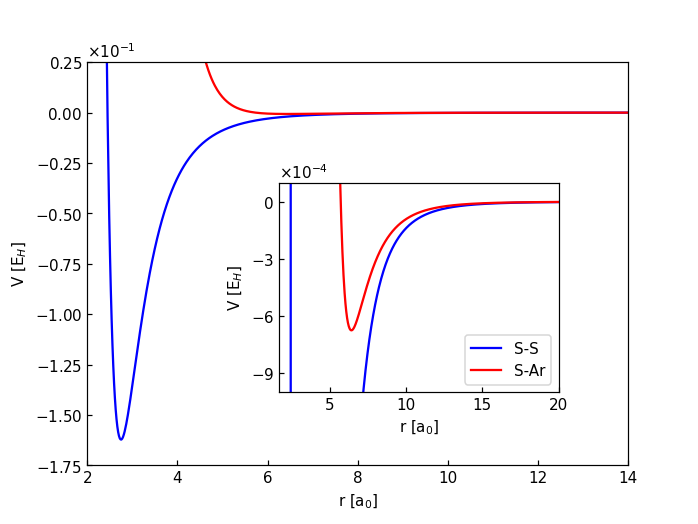

In [61]:
fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.4, 0.25, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(x,input_dict['v12'](x), label = r'S-S', color = 'blue')
ax1.plot(x,input_dict['v23'](x), label = 'S-Ar', color = 'red')
ax2.plot(x,input_dict['v12'](x), label = r'S-S', color = 'blue')
ax2.plot(x,input_dict['v23'](x), label = 'S-Ar', color = 'red')

ax1.set_ylim(-.175,2.5e-2)
ax1.set_xlim(2,14)

ax2.set_ylim(-1e-3,1e-4)
ax2.set_xlim(1.7,20)

ax1.tick_params(which='both',direction='in')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax2.tick_params(which='both',direction='in')
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.set_ylabel(r'V [E$_H$]')
ax2.set_ylabel(r'V [E$_H$]')
ax1.set_xlabel(r'r [$\mathrm{a_0}$]')
ax2.set_xlabel(r'r [$\mathrm{a_0}$]')
ax2.legend()
plt.savefig('figures/potentials.png',dpi=300)
plt.show()

In [30]:
SS_c6 = 140
SS_de = 101.79/627.503 # Hartree
SS_rd = (SS_c6/2/SS_de)**(1/6) # 3.57 a0
# Match rm
SS_re = 3.57
SS_c12d = SS_c6*SS_rd**6/2
SS_c12r = SS_c6*SS_re**6/2
# S-Ar
SAr_c6 = 95.27
SAr_de = 0.424/627.503 # Hartree
SAr_rd = (SAr_c6/2/SAr_de)**(1/6) # 7.16
SAr_re= 7.16
SAr_c12d = SAr_c6*SAr_rd**6/2
SAr_c12r = SAr_c6*SAr_re**6/2

SS_vd = lambda x: potentials.LJ(x,m=12,n=6,cm=SS_c12d,cn=SS_c6)
SS_vr = lambda x: potentials.LJ(x,m=12,n=6,cm=SS_c12r,cn=SS_c6)

SAr_vd = lambda x: potentials.LJ(x,m=12,n=6,cm=SAr_c12d,cn=SAr_c6)
SAr_vr = lambda x: potentials.LJ(x,m=12,n=6,cm=SAr_c12r,cn=SAr_c6)

In [247]:
SS_c12d, SS_c12r

(30206.942725218567, 144912.9964449894)

In [248]:
SAr_c12d, SAr_c12r

(3358166.995205599, 6418067.840814333)

<IPython.core.display.Javascript object>


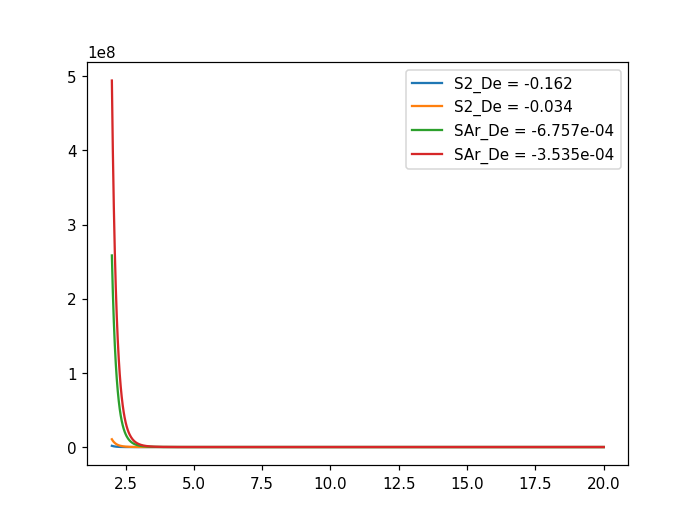

In [186]:
plt.figure()
plt.plot(x,SS_vd(x)/constants.K2Har,label=f'S2_De = {SS_vd(SS_rd):.3f}')
plt.plot(x,SS_vr(x)/constants.K2Har,label=f'S2_De = {SS_vr(SS_re):.3f}')
plt.plot(x,SAr_vd(x)/constants.K2Har,label=f'SAr_De = {SAr_vd(SAr_rd):.3e}')
plt.plot(x,SAr_vr(x)/constants.K2Har,label=f'SAr_De = {SAr_vr(SAr_re):.3e}')
plt.legend()
plt.show()

In [219]:
opac12 = analysis.opacity('results/s32/c12/short.txt').reset_index()

In [220]:
bmax_AB12, bmax_BB12 = analysis.bmax('results/s32/c12/short.txt',tol_AB=0,n_AB=3,tol_BB=0.01,n_BB=2)
rate12 = analysis.k3('results/s32/c12/short.txt',mu,bmax_AB12,bmax_BB12).reset_index()

<IPython.core.display.Javascript object>


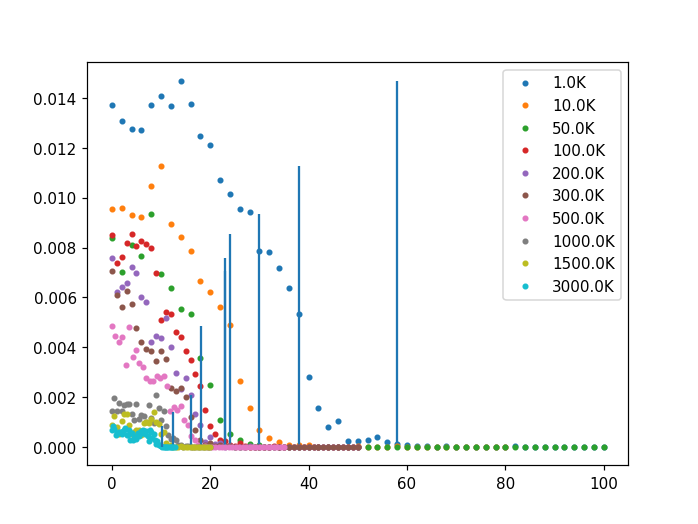

In [221]:
plt.figure()
for e in opac12.e.unique():
    oe = opac12[opac12['e']==e]
    plt.plot(oe['b'],oe['pBB'],'.', label = f'{e}K')
    plt.vlines(bmax_BB12[e],0,oe['pBB'].max())
plt.legend()

<IPython.core.display.Javascript object>


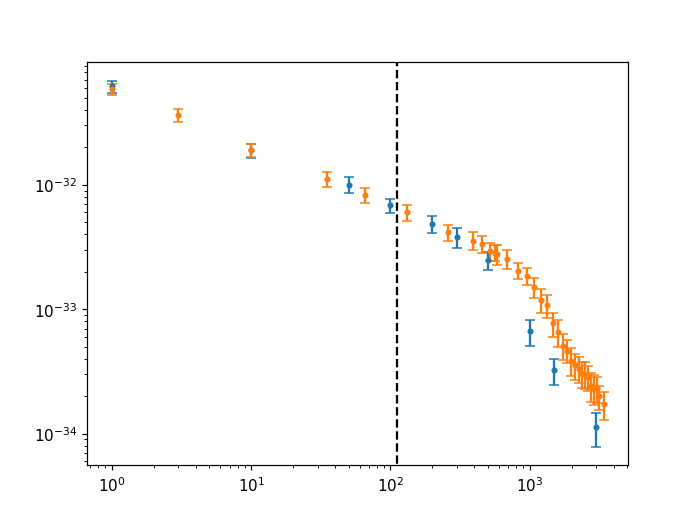

In [222]:
plt.figure()
plt.errorbar(rate12['e'],rate12['k3_BB'],rate12['k3_BB_err'],fmt='.',capsize=3)
# plt.errorbar(rate12['e'],rate12['k3_AB'],rate12['k3_AB_err'],fmt='.',capsize=3)
plt.errorbar(rate['e'],rate['k3_BB'],rate['k3_BB_err'],fmt='.',capsize=3)
# plt.errorbar(rate['e'],rate['k3_AB'],rate['k3_AB_err'],fmt='.',capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.vlines(112,1e-35,1e-30,linestyles='dashed',colors='black', label = 'De (S-Ar)')


<IPython.core.display.Javascript object>


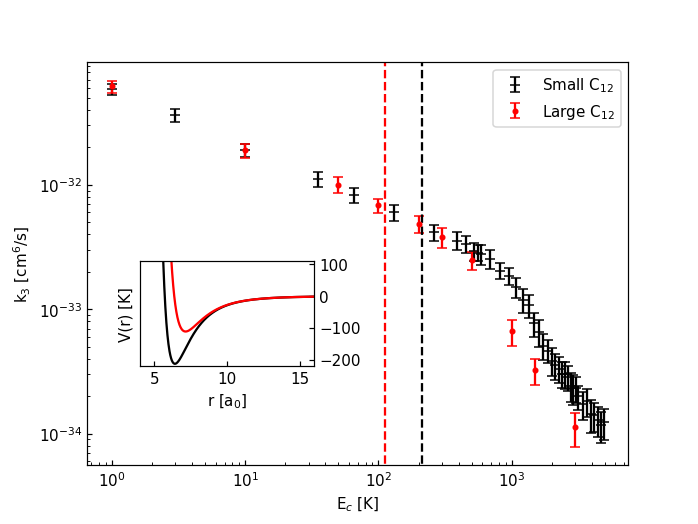

In [267]:
fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.2, 0.3, 0.25, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.errorbar(rate['e'],rate['k3_BB'],rate['k3_BB_err'],fmt='_',capsize=3, color = 'black', label = r'Small C$_{12}$')
ax1.errorbar(rate12['e'],rate12['k3_BB'],rate12['k3_BB_err'],fmt='.',capsize=3, color = 'red', label = r'Large C$_{12}$')
ax2.plot(x,SAr_vd(x)/constants.K2Har, color = 'black')
ax2.plot(x,SAr_vr(x)/constants.K2Har, color = 'red')
ax1.tick_params(which='both',direction='in')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.vlines(213,8e-36,1e-30,linestyles='dashed',colors='black')
ax1.vlines(112,8e-36,1e-30,linestyles='dashed',colors='red')
# ax1.set_ylim(.5e-35,1e-31)
# ax1.set_xlim(2,14)

ax2.set_ylim(-220,110)
ax2.set_xlim(4,16)

ax1.legend()

# ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax2.tick_params(which='both',direction='in')
# ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.tick_right()
ax1.set_ylabel(r'k$_3$ [$\mathrm{cm^6/s}$]')
ax2.set_ylabel(r'V(r) [K]')
ax1.set_xlabel(r'E$_c$ [K]')
ax2.set_xlabel(r'r [$\mathrm{a_0}$]')
# ax2.legend()
# ax1.set_title('S-S')

# plt.savefig('figures/c12.png',dpi=300)